---
# 🕵️‍♂️ Detecção de Fraudes
**Comparação de Modelos: Regressão Logística, MLP e Transformer**

---

## 🔍 Visão Geral
Este notebook apresenta um estudo comparativo de **três abordagens** para detecção de fraudes em transações financeiras:  
- **Regressão Logística** (baseline simples e interpretável)  
- **MLP (Perceptron Multicamadas)** – Rede densa para capturar relações não-lineares  
- **Transformer Tabular** – Modelo avançado com atenção para dados estruturados  

---



In [1]:
# Bibliotecas padrão e científicas
import math                               # Funções matemáticas (log, exp, etc.) usadas no PositionalEncoding
import numpy as np                        # Vetores/matrizes e operações numéricas
import pandas as pd                       # Manipulação de dados em DataFrames
import matplotlib.pyplot as plt           # Visualização de gráficos

# Scikit-learn: split, pré-processamento, modelos e métricas
from sklearn.model_selection import train_test_split        # Divide dados em treino/teste com estratificação
from sklearn.preprocessing import StandardScaler            # Padronização (média=0, desvio=1)
from sklearn.linear_model import LogisticRegression         # Modelo baseline de classificação linear
from sklearn.metrics import (                               # Conjunto de métricas e curvas de avaliação
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

# Imbalanced-learn: técnicas para lidar com classes desbalanceadas
from imblearn.over_sampling import SMOTE                    # Oversampling com geração de exemplos sintéticos
from imblearn.combine import SMOTEENN                       # Combina SMOTE (over) + ENN (limpeza por vizinhos)

# PyTorch: deep learning (MLP e Transformer tabular)
import torch
import torch.nn as nn                                       # Módulos de rede (camadas, perdas, etc.)
import torch.nn.functional as F                             # Funções (ReLU, softmax, etc.)
from torch.utils.data import DataLoader, TensorDataset      # Datasets tensoriais e carregadores de lote


---

## ⚙️ Pipeline de Pré-Processamento
- Divisão do dataset em **treino** e **teste**.  
- **Normalização** dos dados com *fit* apenas no treino (evita vazamento de dados).  
- **Balanceamento** da classe minoritária com **SMOTE** (aplicado apenas no treino).  

Fluxo resumido:  
`split → scaler (fit no treino) → SMOTE (treino)`  

---

In [2]:
# Definição de uma semente fixa para reprodutibilidade
SEED = 42
np.random.seed(SEED)           # Define a semente do NumPy para resultados consistentes
torch.manual_seed(SEED)        # Define a semente do PyTorch para reprodutibilidade

# Seleção automática do dispositivo (GPU se disponível, caso contrário CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %% [markdown]
# ## 1) Carregar e Pré-processar

# Leitura do dataset 'creditcard.csv' em um DataFrame
df = pd.read_csv("creditcard.csv")

# Separação dos atributos (X) e da variável alvo (y)
X = df.drop("Class", axis=1).values   # Todos os atributos, exceto a coluna 'Class'
y = df["Class"].values                # Coluna alvo indicando fraude (1) ou não (0)

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,                                # Dados de entrada
    y,                                # Labels
    test_size=0.2,                    # 20% para teste, 80% para treino
    random_state=SEED,                # Reprodutibilidade na divisão
    stratify=y                        # Mantém a proporção de classes
)

In [3]:
# Padronização dos dados (média = 0, desvio padrão = 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajusta o scaler no treino e transforma
X_test_scaled  = scaler.transform(X_test)      # Usa o mesmo scaler para transformar o teste

# Aumenta o conjunto de treino com dados sintéticos para balancear classes
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

# Conversão para tensores do PyTorch
Xtr_t = torch.tensor(X_train_bal, dtype=torch.float32)  # Features de treino
ytr_t = torch.tensor(y_train_bal, dtype=torch.long)     # Labels de treino
Xte_t = torch.tensor(X_test_scaled, dtype=torch.float32) # Features de teste
yte_t = torch.tensor(y_test, dtype=torch.long)          # Labels de teste

# Criação dos DataLoaders (lotes para treinamento e teste)
train_loader = DataLoader(
    TensorDataset(Xtr_t, ytr_t),
    batch_size=128,    # Tamanho do lote de treino
    shuffle=True       # Embaralha dados a cada época
)
test_loader  = DataLoader(
    TensorDataset(Xte_t, yte_t),
    batch_size=256,    # Lotes maiores no teste, já que não há retropropagação
    shuffle=False      # Ordem fixa no teste
)

# Dimensão de entrada (quantidade de features)
input_dim = X_train_bal.shape[1]

---

## 🧠 Modelos Avaliados
| Modelo                  | Descrição Rápida |
|------------------------|------------------|
| **Regressão Logística** | Baseline rápido e interpretável, útil para triagem inicial. |
| **MLP (Rede Densa)**    | Captura relações não-lineares, custo computacional moderado. |
| **Transformer Tabular** | Modelo de última geração, maior capacidade de generalização. |

---



In [4]:
# Definição de uma Rede Neural Perceptron Multicamadas (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),     # Camada totalmente conectada (entrada -> 64 neurônios)
            nn.BatchNorm1d(64),           # Normalização por lote para estabilidade
            nn.ReLU(),                    # Função de ativação ReLU
            nn.Dropout(0.5),              # Regularização (50% de dropout)
            nn.Linear(64, 32),            # Segunda camada oculta (64 -> 32 neurônios)
            nn.BatchNorm1d(32),           # Normalização por lote
            nn.ReLU(),                    # Ativação ReLU
            nn.Dropout(0.3),              # Dropout de 30%
            nn.Linear(32, 2)              # Camada de saída (2 classes: fraude/não fraude)
        )

    def forward(self, x):
        return self.net(x)                # Propagação direta pelo bloco definido


# Codificação Posicional (usada pelo Transformer)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)                               # Matriz de codificação posicional
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1) # Posições (0, 1, 2, ...)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Preenche com senos (pares) e cossenos (ímpares)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        
        self.register_buffer("pe", pe.unsqueeze(0)) # Registra sem treinar

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]        # Soma codificação posicional ao embedding


# Implementação de um Transformer para dados tabulares
class TabTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, ff=128, layers=2, p=0.1):
        super().__init__()
        self.embed = nn.Linear(1, d_model)  # Embedding de cada feature individual
        self.pos = PositionalEncoding(d_model, num_features) # Codificação posicional
        
        # Camada base do Transformer Encoder
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,          # Dimensão do embedding
            nhead=nhead,              # Cabeças de atenção
            dim_feedforward=ff,       # Dimensão da camada feed-forward
            dropout=p,                # Dropout interno
            batch_first=True          # Processa lotes no formato (batch, seq, feature)
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=layers) # Pilha de camadas encoder
        
        self.drop = nn.Dropout(p)      # Dropout adicional
        self.fc = nn.Linear(d_model, 2)# Camada final de classificação (2 classes)

    def forward(self, x):
        x = x.unsqueeze(-1)           # Adiciona dimensão de "canal" (features individuais)
        x = self.embed(x)             # Projeta cada feature para d_model
        x = self.pos(x)               # Adiciona codificação posicional
        x = self.enc(x)               # Passa pelo Transformer Encoder
        x = self.drop(x.mean(dim=1))  # Faz pooling (média por sequência) + dropout
        return self.fc(x)             # Camada final de classificação

In [5]:
# Função para treinar modelos em PyTorch
def train_torch_model(model, loader, epochs=6, lr=1e-3):
    criterion = nn.CrossEntropyLoss()                # Função de perda para classificação multiclasse
    optim = torch.optim.Adam(model.parameters(), lr=lr) # Otimizador Adam
    
    model.to(device)                                 # Move o modelo para GPU (se disponível) ou CPU
    
    # Loop de treinamento
    for epoch in range(epochs):
        model.train()                                # Modo treino: ativa dropout e batchnorm
        for xb, yb in loader:                        # Itera pelos lotes de treino
            xb, yb = xb.to(device), yb.to(device)    # Move dados para o dispositivo
            optim.zero_grad()                        # Zera gradientes acumulados
            logits = model(xb)                       # Forward pass (saídas do modelo)
            loss = criterion(logits, yb)             # Calcula a perda
            loss.backward()                          # Backpropagation: calcula gradientes
            optim.step()                             # Atualiza pesos do modelo
    return model                                     # Retorna o modelo treinado


# Função para avaliar modelo sem cálculo de gradientes
@torch.no_grad()
def eval_torch_model(model, loader):
    model.eval()                                     # Modo avaliação: desativa dropout/batchnorm
    y_true, y_pred, y_prob = [], [], []              # Listas para rótulos, previsões e probabilidades
    
    for xb, yb in loader:                            # Itera pelos lotes de teste
        xb = xb.to(device)                           # Move dados para o dispositivo
        logits = model(xb)                           # Forward pass
        probs = F.softmax(logits, dim=1)[:,1].cpu().numpy() # Probabilidade da classe positiva
        pred = logits.argmax(dim=1).cpu().numpy()    # Classe prevista (argmax)
        
        # Armazena rótulos reais, previsões e probabilidades
        y_true.extend(yb.numpy())
        y_pred.extend(pred)
        y_prob.extend(probs)
    
    # Converte para arrays NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    
    # Cálculo de métricas clássicas de classificação
    acc = accuracy_score(y_true, y_pred)             # Acurácia
    prec = precision_score(y_true, y_pred)           # Precisão
    rec = recall_score(y_true, y_pred)               # Recall
    f1 = f1_score(y_true, y_pred)                    # F1-Score
    
    # Curva ROC e AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = auc(fpr, tpr)
    
    # Curva Precision-Recall e Average Precision
    prec_c, rec_c, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    
    # Retorna métricas, rótulos, probabilidades e pontos das curvas
    return acc, prec, rec, f1, auc_roc, ap, y_true, y_pred, y_prob, (fpr, tpr), (prec_c, rec_c)

In [6]:
# Treino e Avaliação - SMOTE

# Modelo de Regressão Logística
logreg = LogisticRegression(
    max_iter=800,           # Número máximo de iterações para convergência
    class_weight="balanced",# Ajusta pesos automaticamente para lidar com desbalanceamento
    n_jobs=1                # Número de threads para execução (1 = single-thread)
)
logreg.fit(X_train_bal, y_train_bal)                 # Treina o modelo com dados balanceados pelo SMOTE

# Predição de probabilidades e classes
y_prob_lr = logreg.predict_proba(X_test_scaled)[:,1] # Probabilidade de ser classe positiva
y_pred_lr = (y_prob_lr >= 0.5).astype(int)           # Converte probabilidade em classe (limiar 0.5)

# Métricas de desempenho da Regressão Logística
acc_lr  = accuracy_score(y_test, y_pred_lr)          # Acurácia
prec_lr = precision_score(y_test, y_pred_lr)         # Precisão
rec_lr  = recall_score(y_test, y_pred_lr)            # Recall
f1_lr   = f1_score(y_test, y_pred_lr)                # F1-Score

# Curvas ROC e Precision-Recall
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)     # Pega pontos da curva ROC
auc_lr  = auc(fpr_lr, tpr_lr)                        # AUC-ROC
prec_curve_lr, rec_curve_lr, _ = precision_recall_curve(y_test, y_prob_lr)
ap_lr   = average_precision_score(y_test, y_prob_lr) # Average Precision (AP)

# Modelo MLP (Rede Neural densa)
mlp = MLP(input_dim)                                 # Instancia modelo MLP
mlp = train_torch_model(mlp, train_loader, epochs=6, lr=1e-3) # Treinamento

# Avaliação do MLP
(acc_mlp, prec_mlp, rec_mlp, f1_mlp,
 auc_mlp, ap_mlp, y_true_mlp, y_pred_mlp, y_prob_mlp,
 (fpr_mlp, tpr_mlp), (prec_curve_mlp, rec_curve_mlp)) = eval_torch_model(mlp, test_loader)

# Modelo TabTransformer
trf = TabTransformer(num_features=input_dim)         # Instancia modelo Transformer
trf = train_torch_model(trf, train_loader, epochs=6, lr=1e-3) # Treinamento

# Avaliação do TabTransformer
(acc_trf, prec_trf, rec_trf, f1_trf,
 auc_trf, ap_trf, y_true_trf, y_pred_trf, y_prob_trf,
 (fpr_trf, tpr_trf), (prec_curve_trf, rec_curve_trf)) = eval_torch_model(trf, test_loader)

In [7]:
# Treino e Avaliação - SMOTEENN

# Aplicação do SMOTEENN: Combina SMOTE (oversampling) com ENN (Edited Nearest Neighbors)
# SMOTE gera amostras sintéticas para balancear classes
# ENN remove pontos de fronteira para limpar ruído e melhorar separação entre classes
smote_enn = SMOTEENN(random_state=SEED)
X_train_bal_enn, y_train_bal_enn = smote_enn.fit_resample(X_train_scaled, y_train)

# Conversão para tensores PyTorch (dados de treino balanceados)
Xtr_enn_t = torch.tensor(X_train_bal_enn, dtype=torch.float32)
ytr_enn_t = torch.tensor(y_train_bal_enn, dtype=torch.long)

# DataLoader para treino com SMOTEENN
train_loader_enn = DataLoader(
    TensorDataset(Xtr_enn_t, ytr_enn_t),
    batch_size=128,    # Tamanho do lote
    shuffle=True       # Embaralha os dados a cada época
)

# ---------------------- REGRESSÃO LOGÍSTICA ----------------------
logreg_enn = LogisticRegression(
    max_iter=800,           # Máximo de iterações
    class_weight="balanced",# Ajusta pesos automaticamente
    n_jobs=1                # Usa 1 thread
)
logreg_enn.fit(X_train_bal_enn, y_train_bal_enn)         # Treina com dados SMOTEENN

# Predições e métricas
y_prob_lr_enn = logreg_enn.predict_proba(X_test_scaled)[:,1]  # Probabilidade classe positiva
y_pred_lr_enn = (y_prob_lr_enn >= 0.5).astype(int)            # Converte para classe (limiar 0.5)
acc_lr_enn  = accuracy_score(y_test, y_pred_lr_enn)           # Acurácia
prec_lr_enn = precision_score(y_test, y_pred_lr_enn)          # Precisão
rec_lr_enn  = recall_score(y_test, y_pred_lr_enn)             # Recall
f1_lr_enn   = f1_score(y_test, y_pred_lr_enn)                 # F1-score

# Curvas ROC e PR
fpr_lr_enn, tpr_lr_enn, _ = roc_curve(y_test, y_prob_lr_enn)
auc_lr_enn  = auc(fpr_lr_enn, tpr_lr_enn)
prec_curve_lr_enn, rec_curve_lr_enn, _ = precision_recall_curve(y_test, y_prob_lr_enn)
ap_lr_enn   = average_precision_score(y_test, y_prob_lr_enn)  # AP

# ---------------------- MLP ----------------------
mlp_enn = MLP(input_dim)                                     # Instancia MLP
mlp_enn = train_torch_model(mlp_enn, train_loader_enn, epochs=6, lr=1e-3) # Treinamento

# Avaliação do MLP
(acc_mlp_enn, prec_mlp_enn, rec_mlp_enn, f1_mlp_enn,
 auc_mlp_enn, ap_mlp_enn, y_true_mlp_enn, y_pred_mlp_enn, y_prob_mlp_enn,
 (fpr_mlp_enn, tpr_mlp_enn), (prec_curve_mlp_enn, rec_curve_mlp_enn)) = eval_torch_model(mlp_enn, test_loader)

# ---------------------- TRANSFORMER ----------------------
trf_enn = TabTransformer(num_features=input_dim)              # Instancia TabTransformer
trf_enn = train_torch_model(trf_enn, train_loader_enn, epochs=6, lr=1e-3) # Treinamento

# Avaliação do Transformer
(acc_trf_enn, prec_trf_enn, rec_trf_enn, f1_trf_enn,
 auc_trf_enn, ap_trf_enn, y_true_trf_enn, y_pred_trf_enn, y_prob_trf_enn,
 (fpr_trf_enn, tpr_trf_enn), (prec_curve_trf_enn, rec_curve_trf_enn)) = eval_torch_model(trf_enn, test_loader)

---

## 📊 Métricas Utilizadas
| Métrica         | Definição                                                                 |
|-----------------|--------------------------------------------------------------------------|
| **Accuracy**    | Percentual total de acertos. Pode ser enganoso em datasets desbalanceados. |
| **Precision**   | Entre os casos previstos como fraude, quantos são realmente fraude.       |
| **Recall**      | Proporção de fraudes detectadas em relação ao total de fraudes reais.     |
| **F1-Score**    | Média harmônica entre Precision e Recall.                                 |
| **AUC-ROC**     | Área sob a curva ROC, mede separação entre classes.                      |
| **AP (PR Curve)**| Área sob a curva Precision-Recall, útil em classes desbalanceadas.      |


---

In [ ]:
# Criação de DataFrame com resultados do SMOTE
results_smote = pd.DataFrame([
    {"Amostragem": "SMOTE",       # Técnica de balanceamento utilizada
     "Modelo": "LogReg",          # Modelo avaliado: Regressão Logística
     "Accuracy": acc_lr,          # Acurácia
     "Precision": prec_lr,        # Precisão
     "Recall": rec_lr,            # Recall
     "F1": f1_lr,                 # F1-score
     "AUC-ROC": auc_lr,           # Área sob a curva ROC
     "AP": ap_lr},                # Average Precision
     
    {"Amostragem": "SMOTE", "Modelo": "MLP", 
     "Accuracy": acc_mlp, "Precision": prec_mlp, "Recall": rec_mlp, 
     "F1": f1_mlp, "AUC-ROC": auc_mlp, "AP": ap_mlp},
     
    {"Amostragem": "SMOTE", "Modelo": "Transformer", 
     "Accuracy": acc_trf, "Precision": prec_trf, "Recall": rec_trf, 
     "F1": f1_trf, "AUC-ROC": auc_trf, "AP": ap_trf},
])

# Criação de DataFrame com resultados do SMOTEENN
results_enn = pd.DataFrame([
    {"Amostragem": "SMOTEENN", "Modelo": "LogReg", 
     "Accuracy": acc_lr_enn, "Precision": prec_lr_enn, "Recall": rec_lr_enn, 
     "F1": f1_lr_enn, "AUC-ROC": auc_lr_enn, "AP": ap_lr_enn},
     
    {"Amostragem": "SMOTEENN", "Modelo": "MLP", 
     "Accuracy": acc_mlp_enn, "Precision": prec_mlp_enn, "Recall": rec_mlp_enn, 
     "F1": f1_mlp_enn, "AUC-ROC": auc_mlp_enn, "AP": ap_mlp_enn},
     
    {"Amostragem": "SMOTEENN", "Modelo": "Transformer", 
     "Accuracy": acc_trf_enn, "Precision": prec_trf_enn, "Recall": rec_trf_enn, 
     "F1": f1_trf_enn, "AUC-ROC": auc_trf_enn, "AP": ap_trf_enn},
])

# Concatenação dos dois DataFrames (SMOTE + SMOTEENN)
results_sampling = pd.concat([results_smote, results_enn], ignore_index=True)

# Ordenação das colunas e das linhas
cols = ["Amostragem", "Modelo", "Accuracy", "Precision", "Recall", "F1", "AUC-ROC", "AP"]
results_sampling = (
    results_sampling[cols]               # Seleciona e organiza colunas
    .copy()
    .sort_values(["Amostragem", "Modelo"]) # Ordena por técnica de amostragem e modelo
    .reset_index(drop=True)              # Reseta o índice
)

# Identificação das colunas numéricas para formatação
num_cols = cols[2:]

# Estilização da tabela para exibição
styled = (
    results_sampling.style
        .format({c: "{:.4f}" for c in num_cols})    # 4 casas decimais nas métricas
        .hide(axis="index")                        # Esconde o índice
        .set_table_styles([
            # Estilo do cabeçalho
            {"selector": "th",
             "props": [("background-color", "#1f2937"),  # Cor de fundo do cabeçalho
                       ("color", "white"),               # Texto branco
                       ("font-weight", "bold"),          # Negrito
                       ("text-align", "center"),         # Centralizado
                       ("padding", "8px 10px")]},        # Espaçamento interno
            # Estilo das células
            {"selector": "td",
             "props": [("padding", "6px 10px"),          # Espaçamento interno
                       ("border-bottom", "1px solid #ddd")]} # Linha inferior sutil
        ])
)

# Exibição da tabela estilizada no notebook
display(styled)

Amostragem,Modelo,Accuracy,Precision,Recall,F1,AUC-ROC,AP
SMOTE,LogReg,0.9741,0.0578,0.9184,0.1088,0.9708,0.7245
SMOTE,MLP,0.9943,0.2166,0.8776,0.3475,0.9692,0.7462
SMOTE,Transformer,0.9961,0.2915,0.8776,0.4377,0.9725,0.7159
SMOTEENN,LogReg,0.9732,0.0559,0.9184,0.1054,0.9710,0.7292
SMOTEENN,MLP,0.9949,0.2376,0.8776,0.3739,0.9784,0.7267
SMOTEENN,Transformer,0.9926,0.1747,0.8878,0.2919,0.9679,0.7332


In [ ]:
# Função para comparar curvas ROC entre SMOTE e SMOTEENN
def plot_roc_compare(model_name, fpr_a, tpr_a, auc_a, fpr_b, tpr_b, auc_b):
    plt.figure(figsize=(7,5))                           # Define tamanho do gráfico
    plt.plot(fpr_a, tpr_a, label=f"SMOTE (AUC={auc_a:.3f})")     # Curva ROC com SMOTE
    plt.plot(fpr_b, tpr_b, label=f"SMOTEENN (AUC={auc_b:.3f})")  # Curva ROC com SMOTEENN
    plt.plot([0,1],[0,1],'--')                          # Linha de referência (classificador aleatório)
    plt.xlabel("FPR"); plt.ylabel("TPR")                # Eixos: FPR = False Positive Rate, TPR = True Positive Rate
    plt.title(f"ROC - {model_name}")                    # Título com o nome do modelo
    plt.legend(); plt.grid(True, alpha=0.3); plt.show() # Legenda, grade suave e exibição


# Função para comparar curvas Precision-Recall entre SMOTE e SMOTEENN
def plot_pr_compare(model_name, rec_a, prec_a, ap_a, rec_b, prec_b, ap_b):
    plt.figure(figsize=(7,5))
    plt.plot(rec_a, prec_a, label=f"SMOTE (AP={ap_a:.3f})")       # Curva PR com SMOTE
    plt.plot(rec_b, prec_b, label=f"SMOTEENN (AP={ap_b:.3f})")    # Curva PR com SMOTEENN
    plt.xlabel("Recall"); plt.ylabel("Precision")                 # Eixos
    plt.title(f"Precision-Recall - {model_name}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()


# Função para comparar curvas ROC entre diferentes modelos (mesma técnica de amostragem)
def plot_roc_across_models(method_label, curves_dict):
    """
    curves_dict: {"LogReg": (fpr, tpr, auc), "MLP": (...), "Transformer": (...)}
    """
    plt.figure(figsize=(7,5))
    for name, (fpr, tpr, auc_) in curves_dict.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.3f})")      # Plota curva ROC de cada modelo
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC - Comparação entre modelos ({method_label})")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()


# Função para comparar curvas Precision-Recall entre diferentes modelos
def plot_pr_across_models(method_label, curves_dict):
    """
    curves_dict: {"LogReg": (rec, prec, ap), ...}
    """
    plt.figure(figsize=(7,5))
    for name, (rec, prec, ap_) in curves_dict.items():
        plt.plot(rec, prec, label=f"{name} (AP={ap_:.3f})")       # Plota curva PR de cada modelo
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall - Comparação entre modelos ({method_label})")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()


# Função para gerar gráfico de barras com métricas de modelos
def bar_compare(df, title, metric="F1"):
    plt.figure(figsize=(7,4))
    plt.bar(df["Modelo"], df[metric])                  # Barras com a métrica escolhida
    plt.ylim(0,1); plt.ylabel(metric); plt.title(title)
    for i,v in enumerate(df[metric].values):           # Anota valores no topo das barras
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


# Barras comparativas de métricas
# Tabelas contendo métricas (AUC, AP, F1, Recall, Precision) para cada modelo
df_smote = pd.DataFrame([
    {"Modelo": "LogReg",      "AUC": auc_lr,      "AP": ap_lr,      "F1": f1_lr,
     "Recall": rec_lr,        "Precision": prec_lr},
    {"Modelo": "MLP",         "AUC": auc_mlp,     "AP": ap_mlp,     "F1": f1_mlp,
     "Recall": rec_mlp,       "Precision": prec_mlp},
    {"Modelo": "Transformer", "AUC": auc_trf,     "AP": ap_trf,     "F1": f1_trf,
     "Recall": rec_trf,       "Precision": prec_trf},
])

df_enn = pd.DataFrame([
    {"Modelo": "LogReg",      "AUC": auc_lr_enn,      "AP": ap_lr_enn,      "F1": f1_lr_enn,
     "Recall": rec_lr_enn,    "Precision": prec_lr_enn},
    {"Modelo": "MLP",         "AUC": auc_mlp_enn,     "AP": ap_mlp_enn,     "F1": f1_mlp_enn,
     "Recall": rec_mlp_enn,   "Precision": prec_mlp_enn},
    {"Modelo": "Transformer", "AUC": auc_trf_enn,     "AP": ap_trf_enn,     "F1": f1_trf_enn,
     "Recall": rec_trf_enn,   "Precision": prec_trf_enn},
])

---
## 📈 Gráficos e Visualizações
- **Curvas ROC**: Avaliação da separação entre classes.  
- **Curvas Precision–Recall**: Melhor para problemas desbalanceados.  
- **Gráficos de Barras Comparativos**: Comparação de métricas entre modelos.  

---

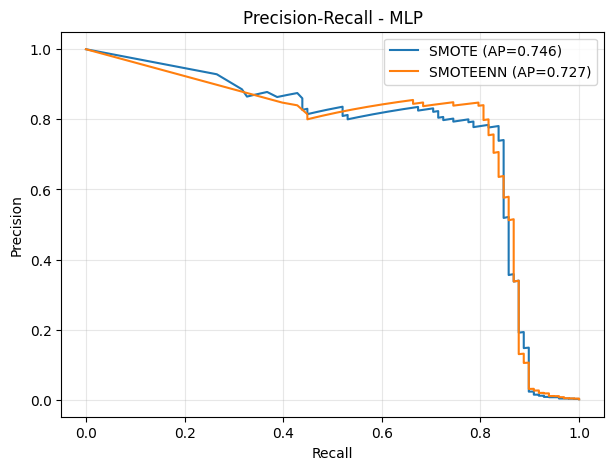

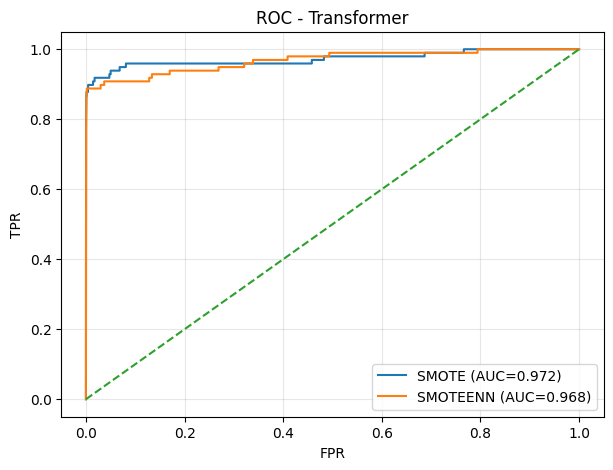

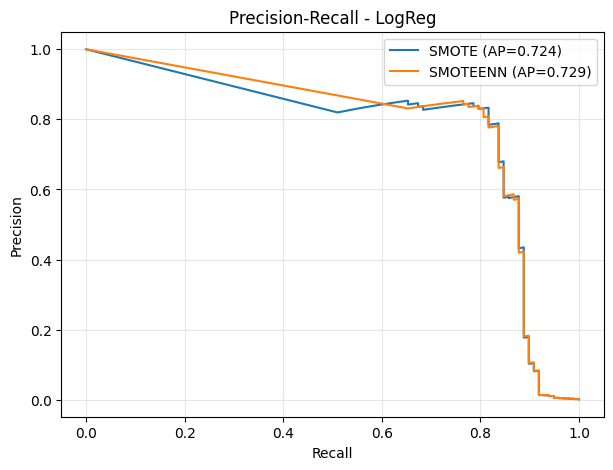

In [ ]:
# Comparação das curvas Precision-Recall entre SMOTE e SMOTEENN para o modelo MLP
plot_pr_compare(
    "MLP",                       # Nome do modelo exibido no título do gráfico
    rec_curve_mlp, prec_curve_mlp, ap_mlp,             # Dados do modelo treinado com SMOTE
    rec_curve_mlp_enn, prec_curve_mlp_enn, ap_mlp_enn  # Dados do modelo treinado com SMOTEENN
)

# Comparação das curvas ROC entre SMOTE e SMOTEENN para o modelo Transformer
plot_roc_compare(
    "Transformer",               # Nome do modelo exibido no título
    fpr_trf, tpr_trf, auc_trf,                   # Dados ROC do Transformer (SMOTE)
    fpr_trf_enn, tpr_trf_enn, auc_trf_enn        # Dados ROC do Transformer (SMOTEENN)
)

# Comparação das curvas Precision-Recall entre SMOTE e SMOTEENN para o modelo LogReg
plot_pr_compare(
    "LogReg",                    # Nome do modelo exibido no título
    rec_curve_lr, prec_curve_lr, ap_lr,                 # Dados do modelo com SMOTE
    rec_curve_lr_enn, prec_curve_lr_enn, ap_lr_enn      # Dados do modelo com SMOTEENN
)

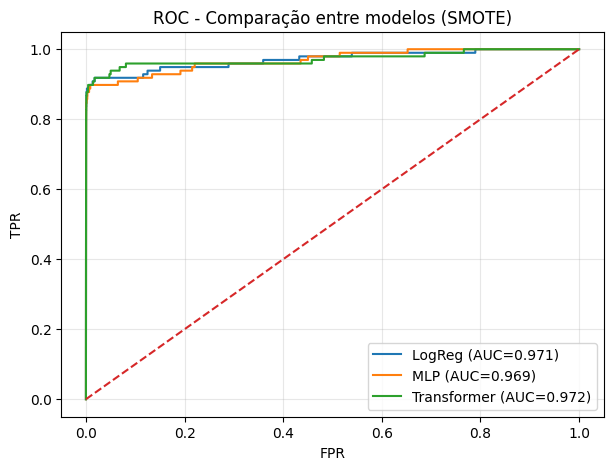

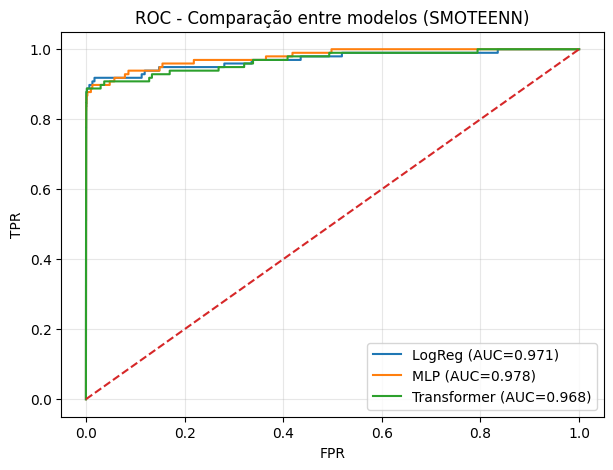

In [ ]:
# Comparação das curvas ROC entre os 3 modelos (LogReg, MLP, Transformer) usando SMOTE
plot_roc_across_models(
    "SMOTE",  # Rótulo do método de amostragem usado (aparece no título do gráfico)
    {
        "LogReg":      (fpr_lr,  tpr_lr,  auc_lr),       # Curva ROC da Regressão Logística
        "MLP":         (fpr_mlp, tpr_mlp, auc_mlp),      # Curva ROC da Rede Neural MLP
        "Transformer": (fpr_trf, tpr_trf, auc_trf),      # Curva ROC do Transformer
    }
)

# Comparação das curvas ROC entre os 3 modelos (LogReg, MLP, Transformer) usando SMOTEENN
plot_roc_across_models(
    "SMOTEENN",  # Rótulo do método de amostragem (SMOTE + ENN)
    {
        "LogReg":      (fpr_lr_enn,  tpr_lr_enn,  auc_lr_enn),     # ROC da Regressão Logística
        "MLP":         (fpr_mlp_enn, tpr_mlp_enn, auc_mlp_enn),    # ROC da MLP
        "Transformer": (fpr_trf_enn, tpr_trf_enn, auc_trf_enn),    # ROC do Transformer
    }
)


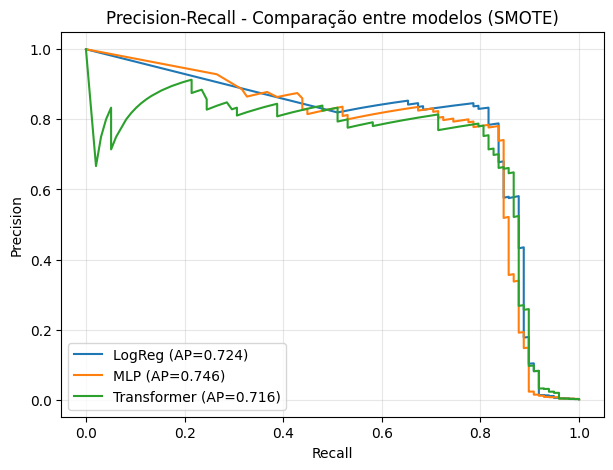

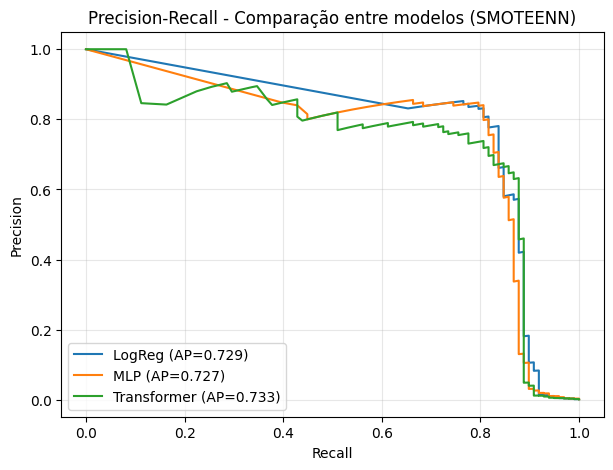

In [ ]:
# Comparação das curvas Precision-Recall (PR) entre os 3 modelos usando SMOTE
plot_pr_across_models(
    "SMOTE",  # Rótulo do método de amostragem (aparece no título do gráfico)
    {
        "LogReg":      (rec_curve_lr,  prec_curve_lr,  ap_lr),       # Curva PR da Regressão Logística
        "MLP":         (rec_curve_mlp, prec_curve_mlp, ap_mlp),      # Curva PR da Rede Neural MLP
        "Transformer": (rec_curve_trf, prec_curve_trf, ap_trf),      # Curva PR do Transformer
    }
)

# Comparação das curvas Precision-Recall (PR) entre os 3 modelos usando SMOTEENN
plot_pr_across_models(
    "SMOTEENN",  # Rótulo do método de amostragem (SMOTE + ENN)
    {
        "LogReg":      (rec_curve_lr_enn,  prec_curve_lr_enn,  ap_lr_enn),     # PR da Regressão Logística
        "MLP":         (rec_curve_mlp_enn, prec_curve_mlp_enn, ap_mlp_enn),    # PR da MLP
        "Transformer": (rec_curve_trf_enn, prec_curve_trf_enn, ap_trf_enn),    # PR do Transformer
    }
)


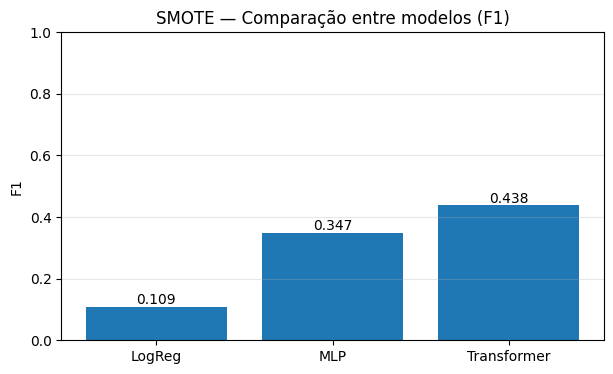

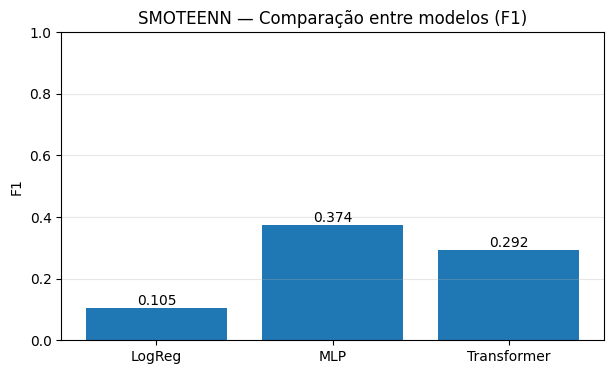

In [ ]:
# Barras por técnica (mude metric para "AUC","AP","Recall","Precision" se quiser)

# Gráfico de barras comparando os modelos (LogReg, MLP, Transformer) usando SMOTE
bar_compare(
    df_smote,                             # DataFrame com métricas dos modelos treinados com SMOTE
    "SMOTE — Comparação entre modelos (F1)",  # Título do gráfico
    metric="F1"                           # Métrica exibida: F1-score
)

# Gráfico de barras comparando os modelos (LogReg, MLP, Transformer) usando SMOTEENN
bar_compare(
    df_enn,                               # DataFrame com métricas dos modelos treinados com SMOTEENN
    "SMOTEENN — Comparação entre modelos (F1)", # Título do gráfico
    metric="F1"                           # Métrica exibida: F1-score
)


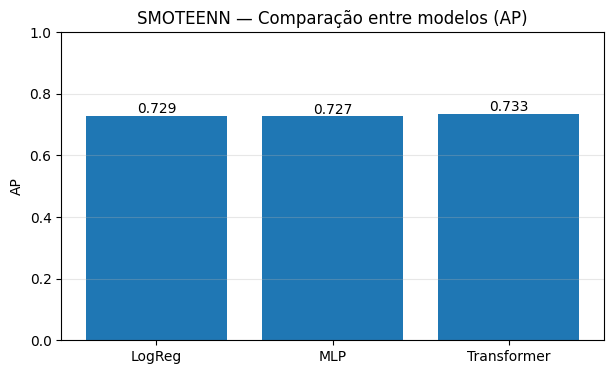

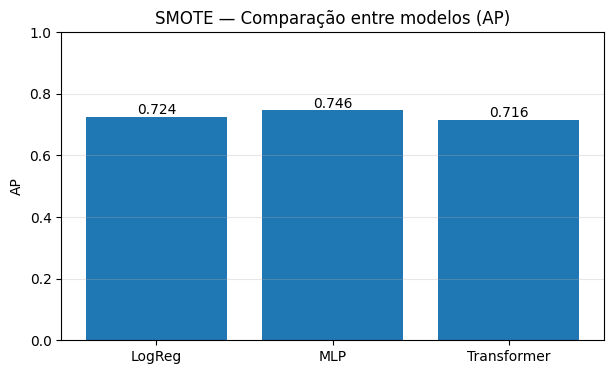

In [ ]:
# Gráfico de barras para comparar Average Precision (AP) entre modelos usando SMOTEENN
bar_compare(
    df_enn,                                   # DataFrame com métricas dos modelos treinados com SMOTEENN
    "SMOTEENN — Comparação entre modelos (AP)", # Título do gráfico
    metric="AP"                               # Métrica exibida: Average Precision (AP)
)

# Gráfico de barras para comparar Average Precision (AP) entre modelos usando SMOTE
bar_compare(
    df_smote,                                 # DataFrame com métricas dos modelos treinados com SMOTE
    "SMOTE — Comparação entre modelos (AP)",    # Título do gráfico
    metric="AP"                               # Métrica exibida: Average Precision (AP)
)
